# Defining the Question


### a) Specifying the Question

> Create a cross-lingual machine learning model focused on Political Hate Speech in Kenya which classifies whether an online post is deemed hate speech and the severity(sub-class) of it if so or not not hate speech (normal speech).

### b) Defining the Metric for Success



> An overall classification accuracy of 80% and Hate Class Recall of 70%.

### c) Understanding the context

> In an increasingly digital era where online social interactions are considered part of the social context, it is proving inevitable that machine learning should be used to protect people from harmful content. This has been evidenced by the multitude of instances where hate speech propagated online (mostly based on misinformation) has led to physical injury and loss of lives across the world. Government institutions should now consider online interactions as spaces where potential crimes may occur just like in the physical world.


> The goal of identifying hate speech efficiently and accurately irrespective of language is becoming a necessity. Countries like Kenya amongst other African nations have experienced the consequences of not dealing with hate speech as evidenced in previous years. Agencies such as the National Cohesion & Integration Commission were formed to help with this. Section 13 of National Cohesion and Integration Act(2008) outlines what is considered hate speech. In combination with the act an automated way of flagging hate speech would prove helpful for the institution given the country’s context which may not be similar to other countries meaning posts may not be picked/flagged by social media companies such as Twitter and Facebook as a result.


> Political hate speech is the greatest area of concern in regards to Kenya and thus we’ll be our area of focus. Looking at whether a post is Hate Speech or Normal Speech and it's severity (sub-class). 


### d) Recording the Experimental Design


> The following design was used:


* Data importation
* Data Reading & Pre-processing
* EDA

### e) Data Relevance

> This was evaluated against the metric of success (after implementation of solution)

## Importing the libraries

In [104]:
#Import libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import csv
#import re
#import preprocessor as tweet_proc
#from transformers import pipeline
#from happytransformer import HappyTextClassification
#from ekphrasis.classes.segmenter import Segmenter
#from emot.emo_unicode import UNICODE_EMO, EMOTICONS
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from nltk import FreqDist
#from pylab import rcParams

## Importing the Dataset


In [105]:
#load dataset
tweets_df = pd.read_csv('/content/merged_hatespeech_dataset - merged_hatespeech_dataset.csv')

In [106]:
#check head
tweets_df.head()

,user,tweet,"hate_speech(1=hspeech, 0=nohspeech)",location,description,friends_count,followers_count,statuses_count,tweet_date,retweet_count,likes,hashtags
0,timothymutuake,@Keiyot_ @JohnRoyMwaniki @KereYvonne @NelsonHa...,1.0,machakos,This is the account of absolute Timothy Mutua,790.0,1675.0,19009.0,2021-04-15 6:35:29,0.0,1.0,[]
1,iamthe_mwas,@MissKwegah1 Luhyas group of food,0.0,Ruaka,"Drink water,eat alot of greens,drink water..,e...",810.0,448.0,6453.0,2021-04-15 6:19:57,0.0,1.0,[]
2,kwibita,"@smileycherry2 Don't beat around the bush, wal...",0.0,Nairobi,"Plumbing Engineer Design&Implementation,planni...",2744.0,1678.0,2316.0,2021-04-15 5:32:02,0.0,4.0,[]
3,ngalih_junior,@Cockey_ninja @AizoOzill Act of generosity whi...,0.0,"Nairobi, Kenya",Football Health and political enthusiast.,3270.0,800.0,129.0,2021-04-14 17:53:15,1.0,2.0,[]
4,allak_weda,@ArapTilingi Luos and Luhyas have been doing t...,0.0,Nairobi,Tech enthusiast & Lone ranger.,315.0,351.0,15017.0,2021-04-14 15:06:36,0.0,0.0,[]


In [107]:
#check tail
tweets_df.tail()

,user,tweet,"hate_speech(1=hspeech, 0=nohspeech)",location,description,friends_count,followers_count,statuses_count,tweet_date,retweet_count,likes,hashtags
5753,NjorogeWaCiku,@DreamMarketKE @moneyacademyKE Kenya is about ...,0.0,Nairobi Kenya,Genre: country,479.0,151.0,1229.0,2021-04-12 2:32:55,0.0,1.0,[]
5754,SharonMusili,There is a reason why you were born in that na...,0.0,"Nairobi, Kenya",Child Of Light,2330.0,1577.0,3895.0,2021-04-12 2:05:57,0.0,1.0,"[{'text': 'PhanerooDevotion', 'indices': [262,..."
5755,gachuhimwangi1,@SakajaJohnson @benayimba But we have been bus...,0.0,"Nairobi, Kenya","A good Dad, HR professional and a farmer.",702.0,106.0,2587.0,2021-04-12 0:54:32,0.0,0.0,[]
5756,GerrJerry,Nyanacheck is walking\nBlessing Odokano is wal...,0.0,"Bungoma, Kenya",Repent Kenya,6155.0,6004.0,1420.0,2021-04-11 22:33:50,0.0,0.0,"[{'text': 'DaysOfHisServant', 'indices': [259,..."
5757,Moses_Ngumbi,@mtaita_ Ride Natty Ride,0.0,Athi-River Kenya,NaN,1609.0,341.0,3061.0,2021-04-11 22:20:33,0.0,0.0,[]


In [108]:
#check number of records
tweets_df.shape

(5758, 12)

In [109]:
#checking column types
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5758 entries, 0 to 5757
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   user                                 5757 non-null   object 
 1   tweet                                5757 non-null   object 
 2   hate_speech(1=hspeech, 0=nohspeech)  5283 non-null   float64
 3   location                             5663 non-null   object 
 4   description                          5174 non-null   object 
 5   friends_count                        5756 non-null   float64
 6   followers_count                      5756 non-null   float64
 7   statuses_count                       5756 non-null   float64
 8   tweet_date                           5756 non-null   object 
 9   retweet_count                        5756 non-null   float64
 10  likes                                5756 non-null   float64
 11  hashtags                      

In [110]:
#checking summary stats
tweets_df.describe()

,"hate_speech(1=hspeech, 0=nohspeech)",friends_count,followers_count,statuses_count,retweet_count,likes
count,5283.000000,5756.000000,5.756000e+03,5.756000e+03,5756.000000,5756.000000
mean,0.243612,2322.930855,1.008193e+04,2.238788e+04,1.987839,10.581480
std,0.429302,7632.819526,7.370993e+04,8.204903e+04,18.146011,102.199885
min,0.000000,0.000000,0.000000e+00,1.000000e+00,0.000000,0.000000
25%,0.000000,319.000000,1.830000e+02,1.111000e+03,0.000000,0.000000
50%,0.000000,821.000000,7.365000e+02,4.306000e+03,0.000000,1.000000
75%,0.000000,2154.000000,2.773250e+03,1.628400e+04,0.000000,3.000000
max,1.000000,135611.000000,1.660277e+06,1.732186e+06,493.000000,3644.000000


In [111]:
#change column name
tweets_df.rename(columns={'hate_speech(1=hspeech, 0=nohspeech)': "label"}, inplace=True)

In [112]:
#checking for nulls
tweets_df.isnull().sum()

user                 1
tweet                1
label              475
location            95
description        584
friends_count        2
followers_count      2
statuses_count       2
tweet_date           2
retweet_count        2
likes                2
hashtags             2
dtype: int64

In [113]:
#extracting only records where tags are not null
tweets_df = tweets_df[tweets_df['label'].notna()]


In [114]:
#checking for nulls
tweets_df.isnull().sum()

user                 0
tweet                0
label                0
location            88
description        559
friends_count        1
followers_count      1
statuses_count       1
tweet_date           1
retweet_count        1
likes                1
hashtags             1
dtype: int64

In [115]:
#fill remaining nulls with mode
tweets_df.iloc[:,3:]=tweets_df.iloc[:,3:].fillna(tweets_df.mode().iloc[0])

In [116]:
#checking for nulls
tweets_df.isnull().sum()

user               0
tweet              0
label              0
location           0
description        0
friends_count      0
followers_count    0
statuses_count     0
tweet_date         0
retweet_count      0
likes              0
hashtags           0
dtype: int64

In [117]:
#check number of records
tweets_df.shape

(5283, 12)

In [118]:
#check duplicates
tweets_df.duplicated().sum()

94

In [119]:
#drop duplicates
tweets_df = tweets_df.drop_duplicates()

In [120]:
#check number of records
tweets_df.shape

(5189, 12)

## Feature Engineering

In [121]:
# getting the hashtags inorder to view the mostly mentioned topics using a word cloud
#cleaning the tags
#remove quotation marks
tweets_df['hashtags'] = tweets_df['hashtags'].str.replace("'", "")

#split using the 1st comma
tweets_df[['first','second']] = tweets_df.hashtags.str.split(",", n=1,expand=True)


#drop/remove special characters
tweets_df['first'] = tweets_df['first'].astype(str)
tweets_df['first'] = tweets_df['first'].str.replace('[', '')
tweets_df['first'] = tweets_df['first'].str.replace(']', '')
tweets_df['first'] = tweets_df['first'].str.replace('{', '')
tweets_df['first'] = tweets_df['first'].str.replace('text: ', '')

#using clean as tags
tweets_df['hashtags'] = tweets_df['first']

#drop unwanted cols
tweets_df.drop(['first','second'], axis=1,inplace=True)


# Exploratory Data Analysis

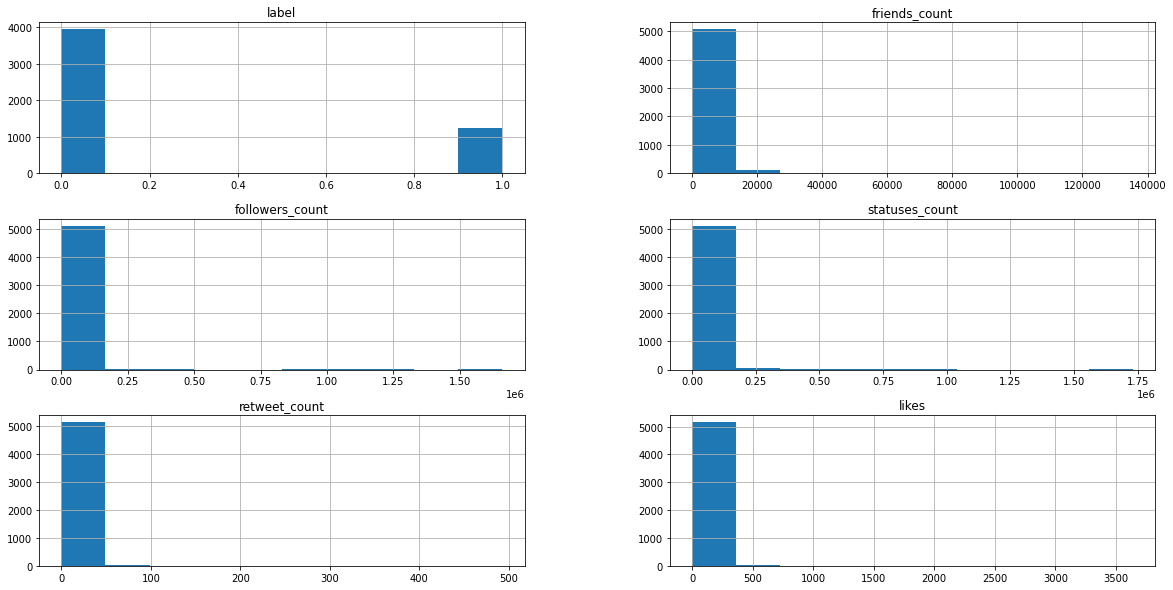

In [122]:
# let us plot histograms to visualize patterns in the data
##create copy to work with
tweet_df = tweets_df.copy(deep=True)

#plot hist
tweet_df.hist(figsize = (20,10))
plt.show()

Text(0.5, 1.0, 'Checking for outliers using boxplots')

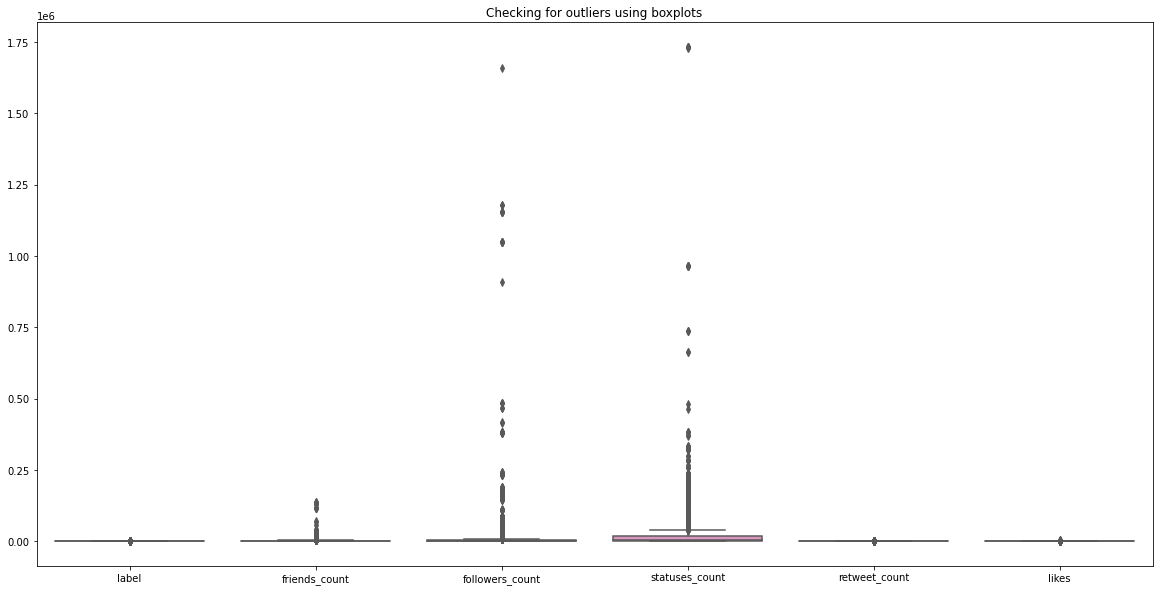

In [123]:
# Boxplots to Visualize outliers of our numerical columns 
plt.figure(figsize = (20,10))
ax = sns.boxplot(data=tweet_df, orient="v", palette="Set2")
plt.title('Checking for outliers using boxplots')
# The boxplots below indicate the outliers in each of the numerical columns

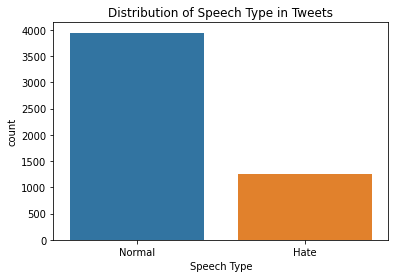

In [124]:
# let us see how the labels are distributed in our dataset
#view data distribution for class imbalance
class_names = ["Normal", "Hate"]
ax = sns.countplot(x = tweet_df['label'])
plt.xlabel('Speech Type')
ax.set_xticklabels(class_names)
plt.title('Distribution of Speech Type in Tweets')
plt.show()

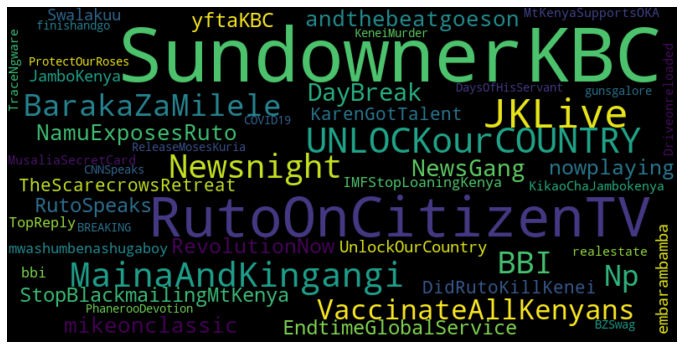

In [125]:
# Most common words using hashtags
#Frequency of words
fdist = FreqDist(tweets_df['hashtags'])
#WordCloud
wc = WordCloud(width=800, height=400, max_words=50).generate_from_frequencies(fdist)
plt.figure(figsize=(12,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [126]:
#save whole dataset
tweets_df.to_csv("final_data.csv")


In [127]:
#save a split as our test data for tweet prediction
#split data to train, test and validation
RANDOM_SEED = 101
df_train, df_test = train_test_split(tweets_df, test_size=0.005, random_state=RANDOM_SEED)

#show shape
print(df_train.shape,df_test.shape)

#save to csv
df_train.to_csv("train_final_data.csv")
df_test.to_csv("deploy_test_final_data.csv")

(5163, 12) (26, 12)
